In [3]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt

import sys
from pathlib import Path

repo_parent = Path.cwd().resolve().parents[0]
if str(repo_parent) not in sys.path:
    sys.path.insert(0, str(repo_parent))

# 3) Autoreload to pick up edits to Maurice2/*
%load_ext autoreload
%autoreload 2

from main.dynamics import Dynamics

In [2]:
xhat0 = np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0]) # Initial state estimate
sampling_rate = 20.0  # Hz
dt = 1.0 / sampling_rate

dynamics = Dynamics(dt=dt, x0=xhat0)
dynamics.setRocketParams(
    I_0=0.327,
    I_f=0.287,
    I_3=0.0035,
    x_CG_0=0.675,
    x_CG_f=0.635,
    m_0=2.944,
    m_f=2.589,
    m_p=0.355,
    d=0.0787,
    L_ne=1.17,
    Cnalpha_rocket=0.207,
    t_motor_burnout=1.971,
    t_launch_rail_clearance=0.308
)
dynamics.setFinParams(
    N=4,
    Cr=0.18,
    Ct=0.0597,
    s=0.0876,
    Cnalpha_fin=2.72025,
    delta=1.0
)
dynamics.setup_eom()
dynamics.forward_euler(xhat=xhat0)

t: 0.000, xhat: [0 0 0 0 0 0 1 0 0 0]
t: 0.050, xhat: [ 0.0000000e+00  0.0000000e+00  5.7335984e-10  0.0000000e+00
  0.0000000e+00 -4.9050000e-01  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
t: 0.050, xhat: [ 0.0000000e+00  0.0000000e+00  5.7335984e-10  0.0000000e+00
  0.0000000e+00 -4.9050000e-01  1.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00]
t: 0.100, xhat: [0.00000000e+00 0.00000000e+00 1.37945932e-04 0.00000000e+00
 0.00000000e+00 4.10108366e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 1.43339960e-11]
t: 0.150, xhat: [0.00000000e+00 0.00000000e+00 9.77695503e-03 0.00000000e+00
 0.00000000e+00 8.94803796e+00 1.00000000e+00 0.00000000e+00
 0.00000000e+00 3.44866263e-06]
t: 0.200, xhat: [0.00000000e+00 0.00000000e+00 5.50246927e-02 0.00000000e+00
 0.00000000e+00 1.39967503e+01 9.99999969e-01 0.00000000e+00
 0.00000000e+00 2.47872531e-04]
t: 0.250, xhat: [0.00000000e+00 0.00000000e+00 1.61543545e-01 0.00000000e+00
 0.00000000e+00 1.91278213e+01 9.99

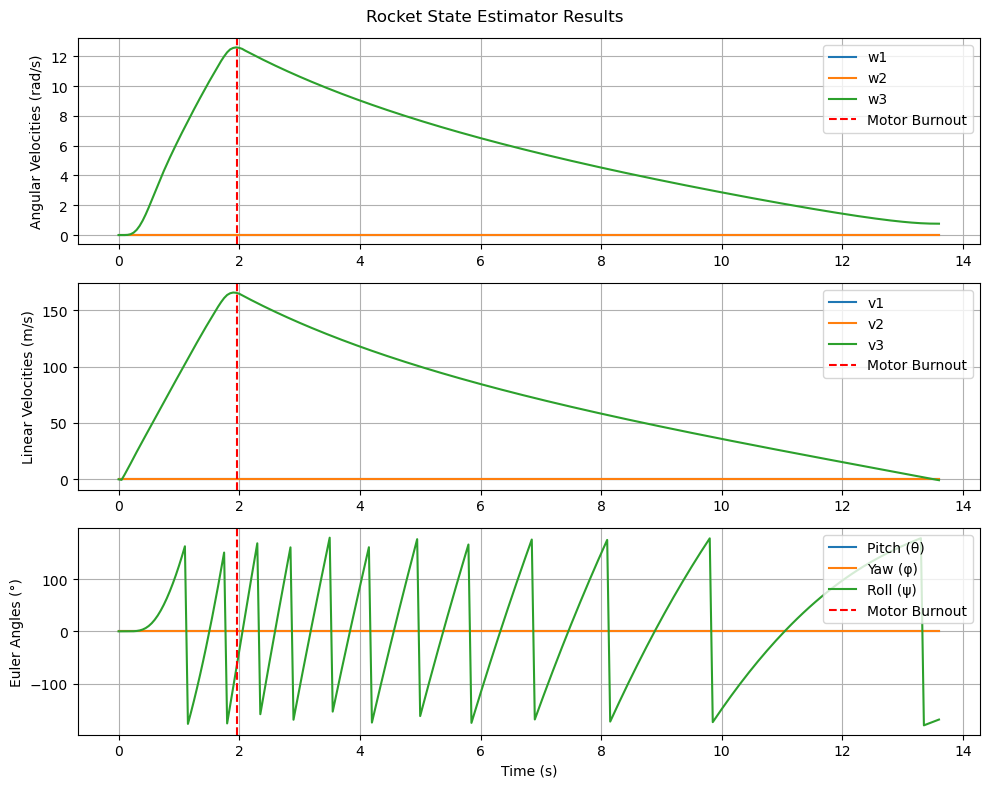

In [3]:
xhat = np.array(dynamics.states)
t = np.arange(0, xhat.shape[0]*dynamics.dt, dynamics.dt)

fig, axs = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
fig.suptitle('Rocket State Estimator Results')
axs[0].plot(t, xhat[:, 0], label='w1')
axs[0].plot(t, xhat[:, 1], label='w2')
axs[0].plot(t, xhat[:, 2], label='w3')
axs[0].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[0].set_ylabel('Angular Velocities (rad/s)')
axs[0].legend(loc='upper right')
axs[0].grid()
axs[1].plot(t, xhat[:, 3], label='v1')
axs[1].plot(t, xhat[:, 4], label='v2')
axs[1].plot(t, xhat[:, 5], label='v3')
axs[1].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[1].set_ylabel('Linear Velocities (m/s)')
axs[1].legend(loc='upper right')
axs[1].grid()

# Convert quaternion to Euler angles for plotting
euler_angles = np.array([dynamics.quat_to_euler_xyz(q) for q in xhat[:, 6:10]])
axs[2].plot(t, np.rad2deg(euler_angles[:, 0]), label='Pitch (θ)')
axs[2].plot(t, np.rad2deg(euler_angles[:, 1]), label='Yaw (φ)')
axs[2].plot(t, np.rad2deg(euler_angles[:, 2]), label='Roll (ψ)')
axs[2].axvline(dynamics.t_motor_burnout, color='r', linestyle='--', label='Motor Burnout')
axs[2].set_ylabel('Euler Angles (°)')
axs[2].set_xlabel('Time (s)')
axs[2].legend(loc='upper right')
axs[2].grid()
plt.tight_layout()

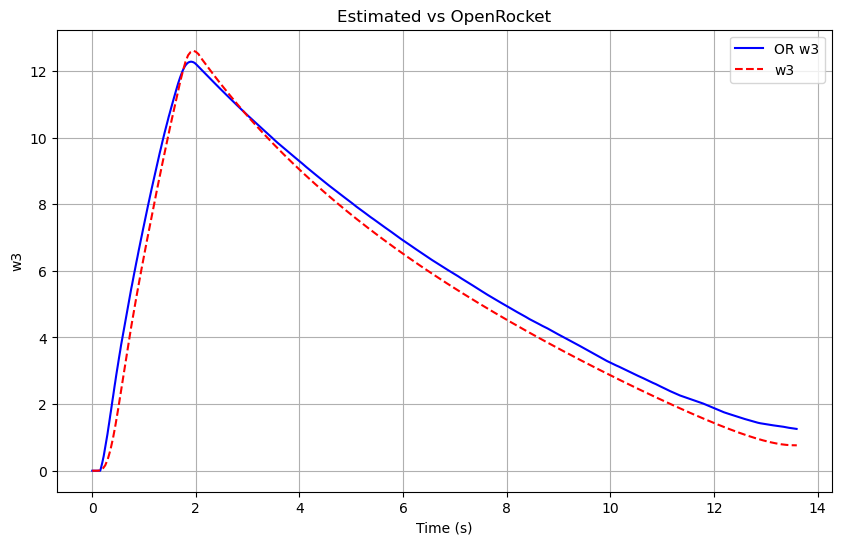

In [4]:
# Compare with OpenRocket data
import pandas as pd
openrocket_data = pd.read_csv("/Users/dsong/Library/CloudStorage/OneDrive-UniversityofIllinois-Urbana/Courses/25-26/Fall 2025/AE 370/370 Projects/370 Project 1/ae370-project1/data/openrocket_data2.csv")
time = openrocket_data['# Time (s)']
mask = time <= t[-1]
v3_or = openrocket_data['Vertical velocity (m/s)'][mask]
w3_or = openrocket_data['Roll rate (°/s)'][mask]
v3_dyn = xhat[:, 5]
w3_dyn = xhat[:, 2]
plt.figure(figsize=(10, 6))
plt.plot(time[mask], np.deg2rad(w3_or), label='OR w3', color='blue')
plt.plot(t, w3_dyn, label='w3', color='red', linestyle='--')
# plt.plot(time[mask], v3_or, label='OR v3', color='blue')
# plt.plot(t, v3_dyn, label='v3', color='red', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('w3')
plt.title('Estimated vs OpenRocket')
plt.legend()
plt.grid()
plt.show()

In [ ]:
import os
import time
import pandas as pd
import numpy as np
# Folder for saved simulation data
save_dir = "../data/dt_runs2"
os.makedirs(save_dir, exist_ok=True)

# Time steps to simulate
dt_values = np.array([0.05])  
xhat0 = np.array([0,0,0,0,0,0,1,0,0,0])

def run_and_save(dt):
    filename = f"rk4_dt{dt:.3f}.csv"
    filepath = os.path.join(save_dir, filename)

    # Skip if it already exists
    if os.path.exists(filepath):
        print(f"{filename} already exists, skipping simulation.")
        return

    print(f"\nRunning simulation for Δt = {dt:.4f} s ...")
    dynamics = Dynamics(dt=dt, x0=xhat0)
    dynamics.setRocketParams(
        I_0=0.327,
        I_f=0.287,
        I_3=0.0035,
        x_CG_0=0.675,
        x_CG_f=0.635,
        m_0=2.944,
        m_f=2.589,
        m_p=0.355,
        d=0.0787,
        L_ne=1.17,
        Cnalpha_rocket=0.207,
        t_motor_burnout=1.971,
        t_launch_rail_clearance=0.308
    )
    dynamics.setFinParams(
        N=4,
        Cr=0.18,
        Ct=0.0597,
        s=0.0876,
        Cnalpha_fin=2.72025,
        delta=1.0
    )
    dynamics.setup_eom()

    start = time.time()
    dynamics.run_rk4(xhat0)
    runtime = time.time() - start

    data = np.column_stack((dynamics.ts, np.array(dynamics.states)))
    cols = ['t', 'w1','w2','w3','v1','v2','v3','qw','qx','qy','qz']
    df = pd.DataFrame(data, columns=cols)
    df.to_csv(filepath, index=False)

    print(f"Saved {filename} ({len(dynamics.ts)} steps, runtime {runtime/60:.1f} min)")
    return filepath

for dt in dt_values:
    run_and_save(dt)

print("\nAll simulations complete.")


Running simulation for Δt = 0.0500 s ...
t: 0.050
t: 0.100
t: 0.150
t: 0.200
t: 0.250
t: 0.300
t: 0.350
t: 0.400
t: 0.450
t: 0.500
t: 0.550
t: 0.600
t: 0.650
t: 0.700
t: 0.750
t: 0.800
t: 0.850
t: 0.900
t: 0.950
t: 1.000
t: 1.050
t: 1.100
t: 1.150
t: 1.200
t: 1.250
t: 1.300
t: 1.350
t: 1.400
t: 1.450
t: 1.500
t: 1.550
t: 1.600
t: 1.650
t: 1.700
t: 1.750
t: 1.800
t: 1.850
t: 1.900
t: 1.950
t: 2.000
t: 2.050
t: 2.100
t: 2.150
t: 2.200
t: 2.250
t: 2.300
t: 2.350
t: 2.400
t: 2.450
t: 2.500
t: 2.550
t: 2.600
t: 2.650
t: 2.700
t: 2.750
t: 2.800
t: 2.850
t: 2.900
t: 2.950
t: 3.000
t: 3.050
t: 3.100
t: 3.150
t: 3.200
t: 3.250
t: 3.300
t: 3.350
t: 3.400
t: 3.450
t: 3.500
t: 3.550
t: 3.600
t: 3.650
t: 3.700
t: 3.750
t: 3.800
t: 3.850
t: 3.900
t: 3.950
t: 4.000
t: 4.050
t: 4.100
t: 4.150
t: 4.200
t: 4.250
t: 4.300
t: 4.350
t: 4.400
t: 4.450
t: 4.500
t: 4.550
t: 4.600
t: 4.650
t: 4.700
t: 4.750
t: 4.800
t: 4.850
t: 4.900
t: 4.950
t: 5.000
t: 5.050
t: 5.100
t: 5.150
t: 5.200
t: 5.250
t: 5.300
t: 5